# A Minimal example of custom acquisiton function
This notebooks covers the consideration for setting up a Custom Acquistions function, and optimising it with botorch and Ax.

Problem description:
- TODO: flesh this out: why do we not just use the gp to model objective = pdf * underling function in this example (and in general)

This notebook covers:
- Set up (through botorch):
    - problem (true underling function and datapoint)
    - Setup GP
- Basic Acquistion function:
    - `__init__` and `forward` inputs and outputs
    - Behaviour expected by the things that then optimise this.
- Optimisation of Acqusitions function (through Botorch):
    - Brute force scoring of acquisiton function over the domain
    - High level botorch automatic tool `optimise_acqf` (builds on the bellow)
    - lower level botorch (`gen_batch_initial_conditions`, `gen_candidates_scipy`)
    - Direct `scipy` optimisation
- Multiple rounds of DOE (gp + acquistion -> pick new point and train new gp)
    - TODO: what is the true optimal of the problem
    - refit hyperparams every step (and condition)
    - don't refit hyperparms each step (just condition)
- Put into `Ax` framework.
    - Set up the `acqf_input_constructor` required
    - ax.BotorchModel using custom acquistion and acquistion args (all wraped in TorchModelBridge)
    - Wrapping above into a `GenerationStratergy`
- Exploration
    - WIP: Supporting q = 2 optimisation, using sequential q=1. This is similar to lookahead
    - Differntiation through 2 levels of fantasy GPs

In [2]:
from typing import Any

import gpytorch
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import torch
from ax.core import (
    Arm,
    Data,
    Experiment,
    Metric,
    Objective,
    OptimizationConfig,
    ParameterType,
    RangeParameter,
    Runner,
    SearchSpace,
)
from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy
from ax.modelbridge.registry import Models
from ax.plot.slice import plot_slice
from ax.utils.common.result import Ok
from ax.utils.notebook.plotting import render
from botorch.acquisition import input_constructors
from botorch.acquisition.acquisition import AcquisitionFunction
from botorch.acquisition.input_constructors import acqf_input_constructor
from botorch.fit import fit_gpytorch_model
from botorch.generation.gen import gen_candidates_scipy
from botorch.models import SingleTaskGP
from botorch.models.model import Model
from botorch.optim import optimize_acqf
from botorch.optim.initializers import gen_batch_initial_conditions
from botorch.posteriors.gpytorch import GPyTorchPosterior
from botorch.utils.transforms import t_batch_mode_transform
from matplotlib.axes import Axes
from torch.distributions.distribution import Distribution
from torch.distributions.normal import Normal

In [3]:
device = torch.device("cpu")  # "cuda" if torch.cuda.is_available() else "cpu")

# As explained here there are a lot of issues that come up when using dtype = float32 (This is the default for torch
# because its faster than float64) .Specifically this will cause issues with scipy optimise, because it will recommends
# a small step (.4 ->.40000000001), but in the conversion to float34 it will be truncated back to .4, and the model will
#  produce the exact same output
# https://github.com/pytorch/botorch/discussions/1444

torch.set_default_dtype(torch.float64)

## Set up

### Set up the true underlying function
This is the find we model with our GP (e.g the simulator).

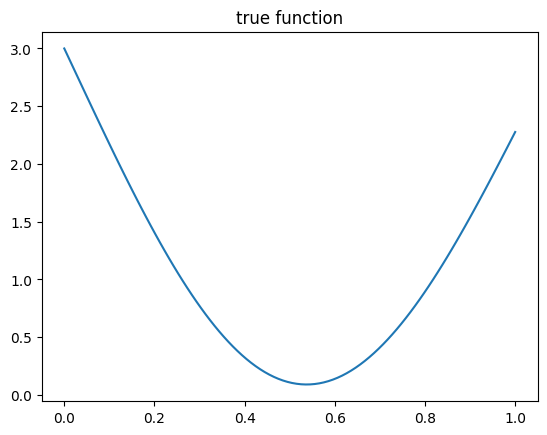

In [4]:
def underling_function(x: torch.Tensor) -> torch.Tensor:
    return -3 * torch.sin(3 * x) - x**2 + 0.7 * x + 3


x = torch.linspace(0, 1, 100)
y_true = underling_function(x)

_ = plt.plot(x.numpy(), y_true.numpy())
_ = plt.title("true function")

### Set up the training data

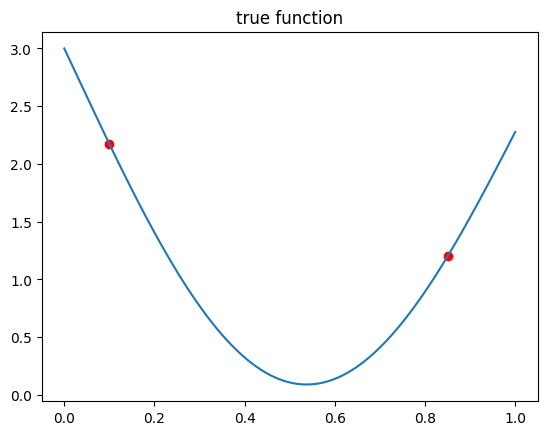

In [5]:
bounds = torch.tensor([[0.0], [1.0]])  # 1D search space [lower_bound, upper_bound]
random_initial_points = 2

train_x = torch.tensor([[0.1], [0.85]])
train_y = underling_function(train_x)


_ = plt.plot(x.numpy(), y_true.numpy())
_ = plt.scatter(train_x.numpy(), train_y.numpy(), c="red")
_ = plt.title("true function")

### Create the GP

In [6]:
# Single task GP: Single independant output, with homoskedastic noise (fit from data)
# Note: this model can be used as is, but the hyperparams have not yet been fit for this specific problem
gp = SingleTaskGP(train_X=train_x, train_Y=train_y)

print(gp)

# mll: marginal log likelihood. This can be thought of as the "loss" function which is thin optimised
# with `fit_gpytorch_model(mll)` to find the hyperparameters (e.g length_scale etc).
mll = gpytorch.mlls.ExactMarginalLogLikelihood(gp.likelihood, gp)
_ = fit_gpytorch_model(mll);

c:\Users\SEBWIN\Documents\technical\code\TDR_rax2\TDR_rax\.venv\Lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning:

Input data is not standardized (mean = tensor([1.6864]), std = tensor([0.6887])). Please consider scaling the input to zero mean and unit variance.



SingleTaskGP(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): MaternKernel(
      (lengthscale_prior): GammaPrior()
      (raw_lengthscale_constraint): Positive()
    )
    (outputscale_prior): GammaPrior()
    (raw_outputscale_constraint): Positive()
  )
)


Show the result of the fitted Gp

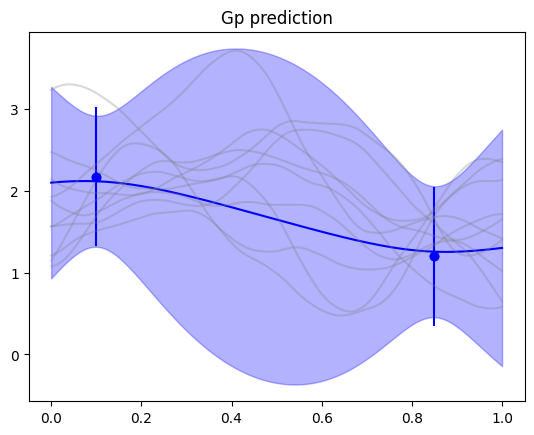

In [7]:
# Like gypytorch, model should be set to eval prior to making predictions
_ = gp.eval()
# The Likelihood also needs to be set to eval if its not automatically within the model likelihood.eval()


# Helper
def plot_gp(model: Model, X: torch.Tensor | None = None, posterior_samples: int = 10, ax: None | Axes = None) -> Axes:  # noqa: N803
    """Plots each of the model targets over the domain. Also plots the training data.

    Args:
        model: assumed to be relevant to this demo problem (targets, domain etc).
            # TODO(sw 2024-11-8): currently only testing with SingleTaskGP
        X: (n,1): Linspace of [0,1] is used by default. Only 1d is currently supported.
        posterior_samples: Number of posterior samples to draw and plot
        ax: will plot to this axis if provied
    """
    X = X if (X is not None) else torch.linspace(0, 1, 201).reshape(-1, 1)  # noqa: N806

    if ax is None:
        _, ax = plt.subplots()

    # Quick and dirty way to ensure consistent colours
    colours = ["b", "c", "m", "y", "k", "r"]

    train_x_all = model.train_inputs[0].detach()
    train_y_all = model.train_targets.detach()
    train_var_all = model.likelihood.noise.detach()

    # t = 1 then:
    # shape model.train_targets: (n)
    # shape model.train_inputs: ((n,d),)
    if len(model.train_targets.shape) == 1:
        n_targets = 1
        # need to add a t dimension to all of these so they can be treated the same way as the multicase
        train_x_all = train_x_all.unsqueeze(0)
        train_y_all = train_y_all.unsqueeze(0)
        train_var_all = train_var_all.unsqueeze(0)

    # t > 1 then:
    # shape model.train_targets: (t,n)
    # shape model.train_inputs: ((t,n,d),)
    else:
        n_targets = model.train_targets.shape[-1]

    for target_idx in range(n_targets):
        c = colours[target_idx % len(colours)]

        train_x = train_x_all[target_idx]
        train_y = train_y_all[target_idx]
        train_var = train_var_all[target_idx]

        with torch.no_grad():
            posterior: GPyTorchPosterior = model.posterior(X)  # type: ignore  # noqa: PGH003

        mean = posterior.mean[:, target_idx]
        var = posterior.variance[:, target_idx]
        _ = ax.fill_between(X.flatten(), mean - 1.95 * var**0.5, mean + 1.95 * var**0.5, alpha=0.3, color=c)
        _ = ax.plot(X, mean, color=c)
        _ = ax.scatter(train_x.flatten(), train_y, color=c)
        _ = ax.errorbar(train_x.flatten(), train_y, 1.95 * train_var**0.5, fmt="o", color=c)

        if posterior_samples > 0:
            samples = posterior.rsample(torch.Size([posterior_samples]))[..., target_idx]
            for sample in samples:
                _ = ax.plot(X.cpu().numpy(), sample.cpu().numpy(), "grey", alpha=0.3)

    _ = ax.set_title("Gp prediction")
    return ax


# test model on 101 regular spaced points on the interval [0, 1]
_ = plot_gp(gp)

## Define mock optimisation problem
Typically, bayesian optimisation is about find the max of the true underling function.

In axtreme, we need to integrated the GP over weather conditions, and we want to find areas of the GP that could reduce uncertainty in this calculation. This is not the same as standard ofptimisation of the GP, so a different approach is needed. This is discussed further in the axtreme package.

Here we set up a more minimal example where:
- We have a GP surrogating some underlying funtion
- The next points that we want to chose if effected by a distribution as well as the GP

While bayesian optimisation could be performed directly on the the objective function we define, the purpose of this is to use a GP and a simple distribution as a placeholder for more complex functionality, and show how CustomAcquisiton functions are integrated.

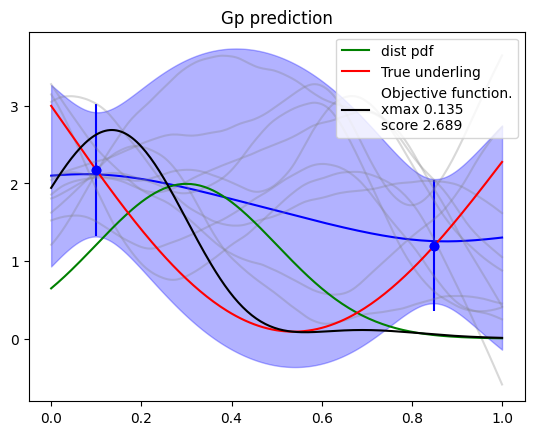

In [8]:
DIST = Normal(0.3, 0.2)


def objective_func(X: torch.Tensor) -> torch.Tensor:  # noqa: N803
    prb = DIST.log_prob(X).exp()
    y_true = underling_function(X)
    return y_true * prb


def plot_gp_and_dist(gp: Model, acquisiton_function: AcquisitionFunction | None = None, ax: Axes | None = None):
    X = torch.linspace(0, 1, 201).reshape(-1, 1)  # noqa: N806

    ax = plot_gp(gp, ax=ax)

    # Add additional plots we find useful.
    # The env dist
    _ = ax.plot(X.numpy(), DIST.log_prob(X).exp(), color="green", label="dist pdf")
    # true fucntion:
    _ = ax.plot(X.numpy(), underling_function(X), color="red", label="True underling")
    # The objectiove function
    objective_results = objective_func(X)
    x_max = X[objective_results.argmax()][0]
    _ = ax.plot(
        X,
        objective_results,
        color="black",
        label=f"Objective function.\nxmax {x_max:.3f}\nscore {objective_results.max():.3f}",
    )
    # formatting
    _ = ax.legend(loc="upper right")

    ax2 = None
    if acquisiton_function:
        scores = acquisiton_function(X.reshape(-1, 1, 1))
        ax2 = ax.twinx()
        _ = ax2.plot(X.detach().numpy(), scores.detach().numpy(), label="ac score", color="orange")
        _ = ax2.set_ylabel("ac_function_score", color="orange")
        _ = ax2.tick_params("y", color="orange")

    return ax2 or ax


_ = plot_gp_and_dist(gp)

Brute force the best result

In [9]:
def estimate_xmax_with_gp(model: Model):
    test_x = torch.linspace(0, 1, 1001)

    with torch.no_grad():
        posterior = model.posterior(test_x)

    y_pred = posterior.mean.flatten()
    prb = DIST.log_prob(test_x).exp()

    objective = y_pred * prb

    return test_x[objective.argmax()]


gp_xmax_est = estimate_xmax_with_gp(gp)
print(f"gp xmax est {gp_xmax_est}. objective_score {objective_func(gp_xmax_est)}")

gp xmax est 0.274. objective_score 1.8181057940929743


## Custom Acqusition function
Define the custom acquisiton function that can be optimisted through `botorch` and `Ax`.

Requirements from `botorch` are detailed here. Requirements from `Ax` are detailed section "Putting into Ax"

In [10]:
# TODO(sw 2024-11-13): need to check if this is the right type of class - there are more specific ones (e.g analytical)
class CustomAcq(AcquisitionFunction):
    "A simple AcquisitionFunction for a 1d problem to demonstrate interface and integeraton."

    def __init__(
        self,
        model: Model,  # Mandatory Param required by the interface
        # Every thing below this point is option that we choose to inlucde
        dist: Distribution,
    ) -> None:
        r"""Constructor for the AcquisitionFunction base class.

        Args:
            model: A fitted model.
            dist: A distribtuion
        """
        super().__init__(model=model)  # create the attribute self.model

        self.dist: Distribution = dist

        # Helper to show the hyperparams of the GP. This is useful to know if the GO is being refit between DOE rounds
        # print(f"\nCustomAcq GP recieved:\n{gp.likelihood.noise=}\n{gp.covar_module.base_kernel.lengthscale=}\n{gp.covar_module.outputscale=}")  # noqa: E501, ERA001

    @t_batch_mode_transform(expected_q=1)  # Ensure function gets X.shape = (t,1,d)
    def forward(self, X: torch.Tensor) -> torch.Tensor:  # type: ignore  # noqa: N803, PGH003
        r"""Evaluate the acquisition function on the candidate set X.

        Args:
            X: A `(b) x q x d`-dim Tensor of `(b)` t-batches with `q` `d`-dim
                design points each. Loosely speaking, q-btaches and t-batchs translate to.
                - `q-batch`: number of points output for a single DoE step. e.g q-batch=2, each time a new GP is trained
                   in the DoE process, it has 2 additional points
                - `t-batch`: The number of independant q-batches being run in parrallel to best make use of hardware.

        Returns:
            A `(b)`-dim Tensor of acquisition function values at the given
            design points `X`. Larger values are considered better.


        Botorch requirements:
        - Requirement from optimisers:
            Gradient: If `X.requires_grad = True` the output must support auto-differentiation from outputs to inputs.
            The use of gradient is determined by the optimisation function applied to this function, and can not
            be turned on/off from within the acquistion function (if turned on will be ignored, if turned off
            ptimisation will throw error). Use of gradient though botorch is controlled with
            `optimize_acqf(..., options = {"with_grad":False})`
            See Notebook section "Botorch Optimisation" for details.

        Ax requirement:
        - Problem/Outcome space vs. Model space
            - Ax shifts everything from problem-space to model-space at the ModelBridge level (e.g TorchModelBridge).
            - As a result, the x value received are in model-space. Need to act accordingly.

        Specific implementation:
        - Provides a simple heuristic of optimising prblem with distributions by focusing on region with high
          distribution probablity, and high GP uncertainty.
        """
        assert X.shape[-1] == 1, "Function only supports 1d input (d=1)"

        prbs = self.dist.log_prob(X).exp()
        # was: (b,1,1), now (b,)
        prbs = prbs.flatten()

        posterior = self.model.posterior(X)
        std = posterior.variance.sqrt().flatten()  # type: ignore  # noqa: PGH003

        return prbs * std

Run the acquistion function

In [11]:
cust_ac = CustomAcq(gp, DIST)
X = torch.tensor([[[0.1]], [[0.5]], [[0.9]]])

# Note: .model.posterior turns of gradient tracking by default. gradient behavior is detailed in the following section
cust_ac(X)

tensor([0.4965, 1.2382, 0.0104], grad_fn=<MulBackward0>)

### Checking Gradient behaviour
Optimisation is controlled by `botorch.optim.optimize.optimize_acqf`, and gradient information is extracted in `botorch.generation.gen.gen_candidates_scipy`. The following mimics how gradient info is acquired in that function. This must produce the correct gradient for gradient based optimisation to be sucessful. Details covered in [Botroch Optimisation](#botroch-optimisation)

Single point

In [12]:
# An acquisition function needs to be optimised with respect to its inputs.
X = torch.tensor([[[0.1]]], requires_grad=True)
# Is turned a maximisation to minimisation problem
loss = -1 * cust_ac(X)
_ = torch.autograd.grad(loss, X)


## This can be used to show the grad graph
# torchviz.make_dot(
#     loss,
#     dict(X = X),  # noqa: ERA001
#     show_attrs=True,  # noqa: ERA001
#     show_saved=True)

Multiple points (t-batch)

In [13]:
# An acquisition function needs to be optimised with respect to its inputs.
X = torch.tensor([[[0.1]], [[0.2]]], requires_grad=True)
# Is turned a maximisation to minimisation problem
loss = -1 * cust_ac(X)
_ = torch.autograd.grad(loss.sum(), X)

## Optimisation of Acquistion:
The acqusition function needs to be compatible with the optimiser that optimises it.
- in `botorch`: `botorch.optim.optimize.optimize_acqf` is used to achieved this.
- in `ax`: When a new point in requested from a Generator in the DoE loop it connects this to `botorch.optim.optimize.optimize_acqf`.

The relationship between from `ax` (bottom), through `botorch`, to `scipy` (top) is described in the following stack trace:

```sh
minimize_with_timeout (botorch\optim\utils\timeout.py:80) 
#   scipy.optimize.minimize  is called here
gen_candidates_scipy (botorch\generation\gen.py:252)
#   "with_grad" used here to determine optimisation approach:
#       if True (line 192): 
#           - makes a wrapper around the acquistion function that give:  acq_wrapper(x) -> (funct_value, func_grad).
#           - jac=True in scipy.optimize.minimize
#       if False (line 224):
#           - wrapper returns:  acq_wrapper(x) -> funct_value
#           - jac=False in scipy.optimize.minimize
_optimize_batch_candidates (botorch\optim\optimize.py:333)
_optimize_acqf_batch (botorch\optim\optimize.py:349)
_optimize_acqf (botorch\optim\optimize.py:584)
optimize_acqf (botorch\optim\optimize.py:563)
optimize (ax\models\torch\botorch_modular\acquisition.py:439)
gen (ax\models\torch\botorch_modular\model.py:395)
_gen (ax\modelbridge\torch.py:682)
gen (ax\modelbridge\base.py:791)
TorchModelBridge.gen()
```

### Brute force
Finding the maximum of the acquistion function. Note, at this point, the optimal of the objective is a long way for the best part of the objective

Optimal values of acquisition: Best x 0.36. score 1.810266278702369


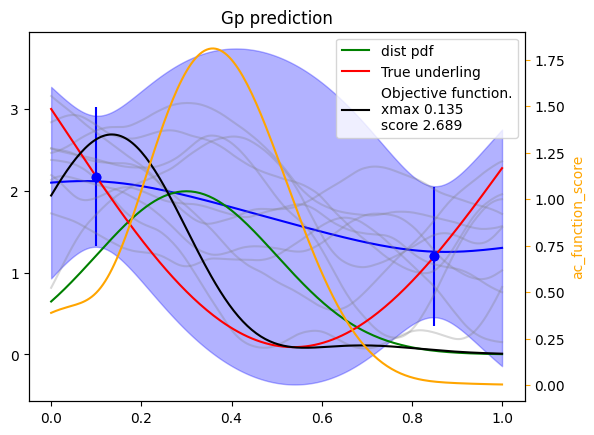

In [14]:
test_x = torch.linspace(0, 1, 101)
scores = cust_ac(test_x.reshape(-1, 1, 1))

print(f"Optimal values of acquisition: Best x {test_x[scores.argmax()]}. score {scores.max()}")

_ = plot_gp_and_dist(gp, acquisiton_function=cust_ac)

### Botroch Optimisation

In [15]:
# Need to provide this with correct gradient information (in the tensor output object)
# OR manually tell it to ignore gradient
candidate, result = optimize_acqf(
    cust_ac,
    bounds=bounds,
    q=1,
    # This is how many different start location will be tried by the optimiser
    num_restarts=5,
    # TODO(sw 2024-11-13): confirm the impact of this paramerter
    # Think this required when using a MCAcquisitionFunction (e.g the Acquistion function output at x is noisey).
    # Controls how many time to repeat an x
    raw_samples=100,
    # Key parameter to control if optimisation should use gradient from the acquisiton fucntion
    options={"with_grad": True},  # True by default
)
candidate, result

(tensor([[0.3583]]), tensor(1.8104))

#### Demonstaration of lower level Botorch optimisation


##### `optimize_acqf` internals


In [16]:
initial_conditions = gen_batch_initial_conditions(cust_ac, bounds, q=1, num_restarts=10, raw_samples=10)
candidates, scores = gen_candidates_scipy(
    initial_conditions=initial_conditions,
    acquisition_function=cust_ac,
    lower_bounds=torch.tensor([0.0]),
    upper_bounds=torch.tensor([1.0]),
    # NOTE: Optimisation fails when this is true
    # if false does an optimisation that ignore the gradient
    # Must mean that we are giveing it bad gradient info in one way or another
    # options = dict(with_grad = False)  # noqa: ERA001
)


# get_best_candidates(candidates, scores)  # noqa: ERA001
candidates[scores.argmax()], scores.max()

(tensor([[0.3583]]), tensor(1.8104))

##### Scipy direct optimisation
Internally botorch evarually used this

In [17]:
"""Make AcqusitionFunction compatible with scipy.optimisation:
- turn it into a minimisation problem
- use numpy

This version doesn't use gradient information
"""


def acq_wrapper(x: torch.Tensor):
    with torch.no_grad():
        x = torch.tensor(x, dtype=torch.float64).reshape(-1, 1, 1)
        acq_result = cust_ac(x)

        # we are using a minimise function, so we need to flip the sign
        return -1 * acq_result.item()

In [18]:
scipy.optimize.minimize(acq_wrapper, x0=[0.3], method="SLSQP", bounds=[(0.0, 1.0)])

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.8103649877035048
       x: [ 3.583e-01]
     nit: 3
     jac: [-5.911e-03]
    nfev: 8
    njev: 3

## DoE
Perform a loop of DoE, where we use the gp and the acquistion function to give use the next datapoint for our acquistion function


### Botorch
#### Retraining the model at each step:

c:\Users\SEBWIN\Documents\technical\code\TDR_rax2\TDR_rax\.venv\Lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning:

Input data is not standardized (mean = tensor([1.6864]), std = tensor([0.6887])). Please consider scaling the input to zero mean and unit variance.

c:\Users\SEBWIN\Documents\technical\code\TDR_rax2\TDR_rax\.venv\Lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning:

Input data is not standardized (mean = tensor([1.2855]), std = tensor([0.8482])). Please consider scaling the input to zero mean and unit variance.

c:\Users\SEBWIN\Documents\technical\code\TDR_rax2\TDR_rax\.venv\Lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning:

Input data is not standardized (mean = tensor([1.2047]), std = tensor([0.7111])). Please consider scaling the input to zero mean and unit variance.

c:\Users\SEBWIN\Documents\technical\code\TDR_rax2\TDR_rax\.venv\Lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning

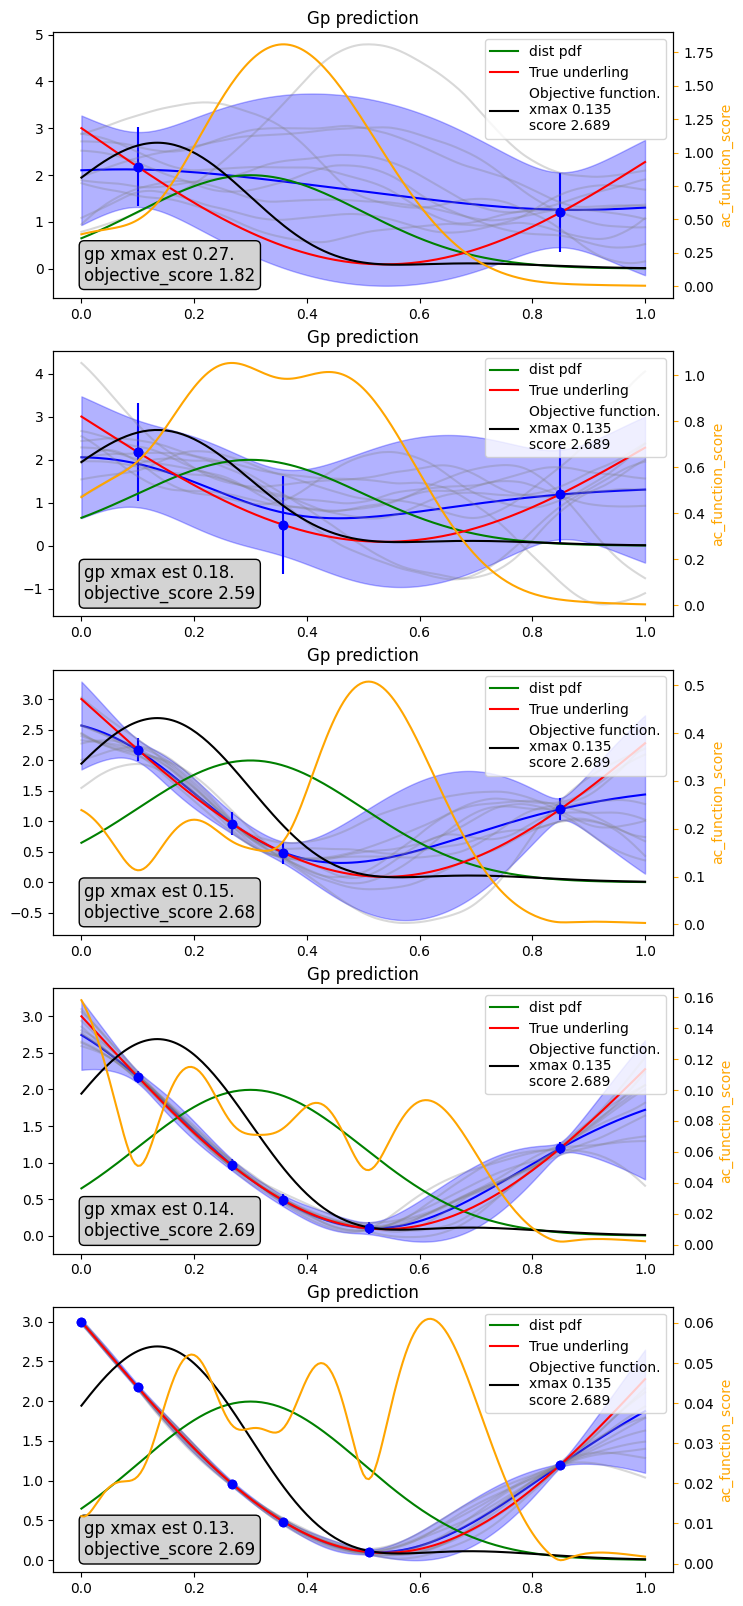

In [19]:
fig, axes = plt.subplots(5, 1, figsize=(8, 20))

bounds = torch.tensor([[0.0], [1.0]])  # 1D search space [lower_bound, upper_bound]
train_x_opt = torch.tensor([[0.1], [0.85]])
train_y_opt = underling_function(train_x_opt)


for ax in axes:
    # Train the GP on the available data
    gp = SingleTaskGP(train_X=train_x_opt, train_Y=train_y_opt)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(gp.likelihood, gp)
    _ = fit_gpytorch_model(mll)
    # Plot it and the acquistion function
    cust_ac = CustomAcq(gp, DIST)

    # estimate the best point in the objective function with the current model
    gp_xmax_est = estimate_xmax_with_gp(gp)
    test_str = f"gp xmax est {gp_xmax_est:.2f}.\nobjective_score {objective_func(gp_xmax_est):.2f}"
    ax.text(
        0.05,
        0.05,
        test_str,
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment="bottom",
        bbox={"boxstyle": "round,pad=0.3", "edgecolor": "black", "facecolor": "lightgray"},
    )

    _ = plot_gp_and_dist(gp, acquisiton_function=cust_ac, ax=ax)

    candidate, result = optimize_acqf(
        cust_ac,
        bounds=bounds,
        q=1,
        num_restarts=5,
        raw_samples=100,
        # If can't provide grad information need to be able to manually set this
        options={"with_grad": True},  # this is True by default
    )

    # call the simulator to give us the new results
    train_x_opt = torch.cat([train_x_opt, candidate])
    train_y_opt = torch.cat([train_y_opt, underling_function(candidate)])

#### Repeat the same, but do not optimise the model hyperparams after the first fit
condition on new data but don't update hyperparams

c:\Users\SEBWIN\Documents\technical\code\TDR_rax2\TDR_rax\.venv\Lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning:

Input data is not standardized (mean = tensor([1.6864]), std = tensor([0.6887])). Please consider scaling the input to zero mean and unit variance.



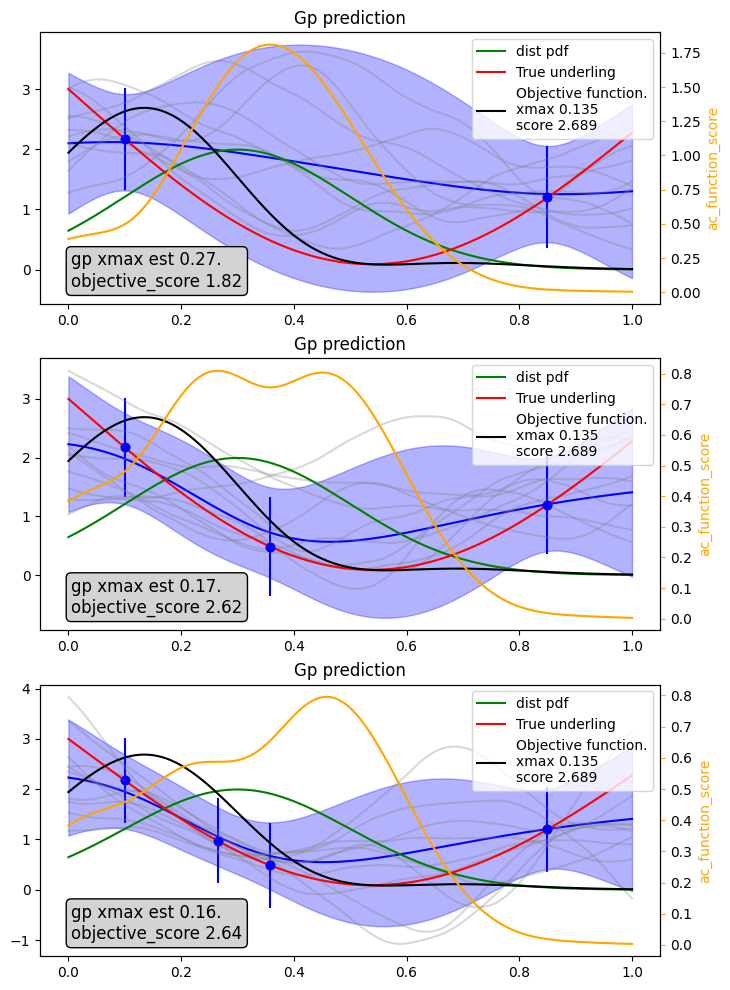

In [20]:
fig, axes = plt.subplots(3, 1, figsize=(8, 12))

bounds = torch.tensor([[0.0], [1.0]])  # 1D search space [lower_bound, upper_bound]
train_x_opt = torch.tensor([[0.1], [0.85]])
train_y_opt = underling_function(train_x_opt)


gp = SingleTaskGP(train_X=train_x_opt, train_Y=train_y_opt)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(gp.likelihood, gp)
_ = fit_gpytorch_model(mll)

for ax in axes:
    # Plot it and the acquistion function
    cust_ac = CustomAcq(gp, DIST)

    # estimate the best point in the objective function with the current model
    gp_xmax_est = estimate_xmax_with_gp(gp)
    test_str = f"gp xmax est {gp_xmax_est:.2f}.\nobjective_score {objective_func(gp_xmax_est):.2f}"
    ax.text(
        0.05,
        0.05,
        test_str,
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment="bottom",
        bbox={"boxstyle": "round,pad=0.3", "edgecolor": "black", "facecolor": "lightgray"},
    )

    _ = plot_gp_and_dist(gp, acquisiton_function=cust_ac, ax=ax)

    candidate, result = optimize_acqf(
        cust_ac,
        bounds=bounds,
        q=1,
        num_restarts=5,
        raw_samples=100,
        # If can't provide grad information need to be able to manually set this
        options={"with_grad": True},  # This is true by default
    )

    # Update the model
    new_x_point = candidate.flatten()
    new_y_point = underling_function(new_x_point)
    gp = gp.get_fantasy_model(inputs=new_x_point, targets=new_y_point)

    # Justed used for plotting now
    train_x_opt = torch.cat([train_x_opt, new_x_point.unsqueeze(0)])
    train_y_opt = torch.cat([train_y_opt, new_y_point.unsqueeze(0)])

## AX
Put this into the ax framework and optimise it that way.
- Come from botorch custom acquistions [here.](https://botorch.org/tutorials/custom_acquisition)
- and Ax example here [here](https://ax.dev/tutorials/modular_botax.html)

There are likely otherways to acheive this with the ax interface

### Set up

Create the experiment

In [ ]:
# For our purposes, the metric is a wrapper that structures the function output.
class DummyMetric(Metric):  # noqa: D101
    def fetch_trial_data(self, trial):  # type: ignore  # noqa: ANN001, D102, PGH003
        records = []
        for arm_name, arm in trial.arms_by_name.items():
            params = arm.parameters
            tensor_params = torch.tensor([params["x"]])
            records.append(
                {
                    "arm_name": arm_name,
                    "metric_name": self.name,
                    "trial_index": trial.index,
                    "mean": underling_function(tensor_params),
                    "sem": float("nan"),  # SEM (observation noise) - NaN indicates unknown
                }
            )
        # OK just wtapps saying it contains a sucessful value
        return Ok(value=Data(df=pd.DataFrame.from_records(records)))


# Search space defines the parameters, their types, and acceptable values.
search_space = SearchSpace(
    parameters=[
        RangeParameter(name="x", parameter_type=ParameterType.FLOAT, lower=0, upper=1),
    ]
)


optimization_config = OptimizationConfig(
    objective=Objective(
        # NOTE: we don't care about lower_is_better because are not just trying to maximise or minimise this value
        # This just needs to be the y value we want to fit our GP to
        metric=DummyMetric(name="dummy_metric", lower_is_better=True),
        minimize=True,  # This is optional since we specified `lower_is_better=True`
    )
)


class MyRunner(Runner):  # noqa: D101
    def run(self, trial):  # type: ignore  # noqa: ANN001, D102, PGH003
        trial_metadata = {"name": str(trial.index)}
        return trial_metadata


exp = Experiment(
    name="Dummy_experiment",
    search_space=search_space,
    optimization_config=optimization_config,
    runner=MyRunner(),
)

Register the input constructor

In [22]:
# Super hacky way of making sure the input constructure is not already in there,
# so we can make updates to this functions without having to restart the notebook
input_constructors.ACQF_INPUT_CONSTRUCTOR_REGISTRY.pop(CustomAcq, None)


@acqf_input_constructor(CustomAcq)
def construct_inputs_custom_acq(
    model: Model,
    dist: Distribution,
    **kwargs: Any,  # noqa: ANN401, ARG001
) -> dict[str, Any]:
    return {
        "model": model,
        "dist": dist,
    }

### Option 1: low level Ax
Note, with this hyperparams are refitted every round of DoE

Manually add some data to the experiment

In [23]:
manual_exp_locations = [[0.1], [0.85]]
for x in manual_exp_locations:
    # this is just a quick and diry unpacking for now, will need to extend to x in higher dims
    trial_arm = exp.new_trial().add_arm(Arm(parameters={"x": x[0]}))
    trial_arm.run()
    trial_arm.mark_completed()

# Check this has been properly attached
_ = display(exp.fetch_data().df)
exp.trials

,arm_name,metric_name,mean,sem,trial_index
0,0_0,dummy_metric,2.173439,NaN,0
1,1_0,dummy_metric,1.199449,NaN,1


{0: Trial(experiment_name='Dummy_experiment', index=0, status=TrialStatus.COMPLETED, arm=Arm(name='0_0', parameters={'x': 0.1})),
 1: Trial(experiment_name='Dummy_experiment', index=1, status=TrialStatus.COMPLETED, arm=Arm(name='1_0', parameters={'x': 0.85}))}

Each loop build a new GP from the available data, and use the custom acquistion function to select a new point

In [24]:
for _ in range(5):
    model_bridge_cust_ac = Models.BOTORCH_MODULAR(
        experiment=exp,
        data=exp.fetch_data(),
        # surrogate=Surrogate(FixedNoiseGP),  # Optional, will use default if unspecified  # noqa: ERA001
        botorch_acqf_class=CustomAcq,  # Optional, will use default if unspecified
        acquisition_options={"dist": DIST},
    )
    trial = exp.new_trial(
        generator_run=model_bridge_cust_ac.gen(
            1,
            # This section is optional. with_grad default to True if not specified here
            model_gen_options={
                "optimizer_kwargs": {
                    "options": {"with_grad": True},
                }
            },
        )
    )
    _ = trial.run()
    _ = trial.mark_completed()

Show the resulting experiment object

In [25]:
exp.fetch_data().df

,arm_name,metric_name,mean,sem,trial_index
0,0_0,dummy_metric,2.173439,NaN,0
1,1_0,dummy_metric,1.199449,NaN,1
2,2_0,dummy_metric,0.486447,NaN,2
3,3_0,dummy_metric,0.955848,NaN,3
4,4_0,dummy_metric,0.101406,NaN,4
5,5_0,dummy_metric,3.000000,NaN,5
6,6_0,dummy_metric,0.168753,NaN,6


In [26]:
render(
    plot_slice(
        model=model_bridge_cust_ac,
        param_name="x",
        metric_name="dummy_metric",
    )
)

We can see this produces the same points as the botorch model that is fully retrained at each step, as expected.

- TODO(sw 2024-11-13): Build the equivalent plot to the botorch component using the Ax interface to the model.

### Option 2: Higher level Ax: Generation Stratergy
Uses higher level ax services. Note, with this hyperparams are refitted every round of DoE

In [27]:
# Make the experiment fresh
exp = Experiment(
    name="Dummy_experiment",
    search_space=search_space,
    optimization_config=optimization_config,
    runner=MyRunner(),
)

In [28]:
gs = GenerationStrategy(
    steps=[
        # Quasi-random initialization step
        GenerationStep(
            model=Models.SOBOL,
            num_trials=2,  # How many trials should be produced from this generation step
            model_kwargs={"seed": 999},  # Any kwargs you want passed into the model
        ),
        # Bayesian optimization step using the custom acquisition function
        GenerationStep(
            model=Models.BOTORCH_MODULAR,
            num_trials=-1,  # No limitation on how many trials should be produced from this step
            # For `BOTORCH_MODULAR`, we pass in kwargs to specify what surrogate or acquisition function to use.
            # `acquisition_options` specifies the set of additional arguments to pass into the input constructor.
            model_kwargs={
                "botorch_acqf_class": CustomAcq,
                "acquisition_options": {"dist": DIST},
            },
        ),
    ]
)

In [29]:
from ax.service.ax_client import AxClient

# Initialize the client - AxClient offers a convenient API to control the experiment
ax_client = AxClient(generation_strategy=gs)

[INFO 11-29 15:15:46] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.


In [30]:
# Not yet supported ax_client.load_experiment('Dummy_experiment')

# Bit of a hacky way to attach it to the higher level thing
_ = ax_client._set_runner(experiment=exp)  # noqa: SLF001
_ = ax_client._set_experiment(  # noqa: SLF001
    experiment=exp,
    overwrite_existing_experiment=True,
)

In [ ]:
# NOTE we have already defined the objective inside the experiement, annoying we need to define it again
def evaluate(parameters):  # type: ignore  # noqa: ANN001, PGH003
    # Note this is just because our objective function works with tensors
    x = torch.tensor([parameters.get("x")], dtype=torch.float64)
    # In our case, standard error is 0, since we are computing a synthetic function.
    return {"dummy_metric": (underling_function(x).item(), 0.0)}

In [32]:
for i in range(5):
    print(f"Running trial {i+1}/30...")
    parameters, trial_index = ax_client.get_next_trial()
    # Local evaluation here can be replaced with deployment to external system.
    ax_client.complete_trial(trial_index=trial_index, raw_data=evaluate(parameters))

[INFO 11-29 15:15:46] ax.service.ax_client: Generated new trial 0 with parameters {'x': 0.62873} using model Sobol.
[INFO 11-29 15:15:46] ax.service.ax_client: Completed trial 0 with data: {'dummy_metric': (0.192786, 0.0)}.
[INFO 11-29 15:15:46] ax.service.ax_client: Generated new trial 1 with parameters {'x': 0.277899} using model Sobol.
[INFO 11-29 15:15:46] ax.service.ax_client: Completed trial 1 with data: {'dummy_metric': (0.896038, 0.0)}.
[INFO 11-29 15:15:46] ax.service.ax_client: Generated new trial 2 with parameters {'x': 0.110243} using model BoTorch.
[INFO 11-29 15:15:46] ax.service.ax_client: Completed trial 2 with data: {'dummy_metric': (2.090818, 0.0)}.


Running trial 1/30...
Running trial 2/30...
Running trial 3/30...
Running trial 4/30...


[INFO 11-29 15:15:47] ax.service.ax_client: Generated new trial 3 with parameters {'x': 0.426317} using model BoTorch.
[INFO 11-29 15:15:47] ax.service.ax_client: Completed trial 3 with data: {'dummy_metric': (0.243532, 0.0)}.
[INFO 11-29 15:15:47] ax.service.ax_client: Generated new trial 4 with parameters {'x': 0.0} using model BoTorch.
[INFO 11-29 15:15:47] ax.service.ax_client: Completed trial 4 with data: {'dummy_metric': (3.0, 0.0)}.


Running trial 5/30...


In [33]:
render(
    plot_slice(
        model=ax_client.generation_strategy.model,
        param_name="x",
        metric_name="dummy_metric",
    )
)

### Option 3:  Alternate way of interacting with the model
- create a botorch model useing the interface `ax.models.torch.botorch` [here](https://ax.dev/api/models.html#module-ax.models.torch.botorch)
- also a relevant tutorial [here](https://botorch.org/tutorials/custom_botorch_model_in_ax)

TODO: Explore this further